In [10]:
# Cell 1: 导入库和环境设置
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import math
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置显示参数
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)

print("T002: 分子过滤 - ADME和先导化合物相似性标准")
print("=" * 60)

# 检查RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Draw, PandasTools
    print("RDKit 导入成功")
except ImportError:
    print("RDKit 未安装，请运行: conda install -c conda-forge rdkit")

T002: 分子过滤 - ADME和先导化合物相似性标准
RDKit 导入成功


In [11]:
# Cell 2: ADME理论介绍
print("ADME概念:")
print("-" * 40)
print("🔹 A - Absorption (吸收): 药物如何进入人体")
print("🔹 D - Distribution (分布): 药物如何在体内移动") 
print("🔹 M - Metabolism (代谢): 药物如何被分解")
print("🔹 E - Excretion (排泄): 药物如何被消除")

print("\nLipinski五规则 (Rule of Five):")
print("-" * 40)
print("如果化合物违反以下规则中的两个或更多，则可能具有较差的口服生物利用度：")
print("• 分子量 ≤ 500 Da")
print("• 氢键受体数 ≤ 10") 
print("• 氢键给体数 ≤ 5")
print("• LogP值 ≤ 5")
print("\n记住：只有当违反超过1个规则时，分子才不符合Ro5")

ADME概念:
----------------------------------------
🔹 A - Absorption (吸收): 药物如何进入人体
🔹 D - Distribution (分布): 药物如何在体内移动
🔹 M - Metabolism (代谢): 药物如何被分解
🔹 E - Excretion (排泄): 药物如何被消除

Lipinski五规则 (Rule of Five):
----------------------------------------
如果化合物违反以下规则中的两个或更多，则可能具有较差的口服生物利用度：
• 分子量 ≤ 500 Da
• 氢键受体数 ≤ 10
• 氢键给体数 ≤ 5
• LogP值 ≤ 5

记住：只有当违反超过1个规则时，分子才不符合Ro5


In [12]:
# Cell 3: 定义示例分子
example_molecules = {
    '环孢素': 'CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C',
    '氯氮平': 'CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C',
    'β-胡萝卜素': 'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C',
    '大麻二酚': 'CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O'
}

print("示例分子 (不同性质的药物):")
print("-" * 50)
for i, (name, smiles) in enumerate(example_molecules.items(), 1):
    print(f"{i}. {name}")
    print(f"   SMILES: {smiles[:60]}...")
    print()

示例分子 (不同性质的药物):
--------------------------------------------------
1. 环孢素
   SMILES: CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N...

2. 氯氮平
   SMILES: CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C...

3. β-胡萝卜素
   SMILES: CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CC...

4. 大麻二酚
   SMILES: CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O...



In [13]:
# Cell 4: 定义Ro5计算函数
def calculate_ro5_properties(smiles):
    """
    计算分子的Lipinski五规则性质
    """
    molecule = Chem.MolFromSmiles(smiles)
    
    if molecule is None:
        return pd.Series([None, None, None, None, False], 
                        index=["分子量", "氢键受体数", "氢键给体数", "LogP值", "符合Ro5"])
    
    # 计算Ro5相关的化学性质
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    
    # 检查Ro5条件
    conditions = [
        molecular_weight <= 500,    # 分子量 ≤ 500 Da
        n_hba <= 10,               # 氢键受体数 ≤ 10
        n_hbd <= 5,                # 氢键给体数 ≤ 5
        logp <= 5                  # LogP ≤ 5
    ]
    
    # 如果违反条件不超过一个，则符合五规则
    ro5_fulfilled = sum(conditions) >= 3
    
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["分子量", "氢键受体数", "氢键给体数", "LogP值", "符合Ro5"]
    )

def analyze_ro5_violations(properties):
    """分析违反了哪些Ro5规则"""
    violations = []
    if properties["分子量"] > 500:
        violations.append(f"分子量过大 ({properties['分子量']:.1f} > 500)")
    if properties["氢键受体数"] > 10:
        violations.append(f"氢键受体数过多 ({properties['氢键受体数']} > 10)")
    if properties["氢键给体数"] > 5:
        violations.append(f"氢键给体数过多 ({properties['氢键给体数']} > 5)")
    if properties["LogP值"] > 5:
        violations.append(f"LogP值过高 ({properties['LogP值']:.2f} > 5)")
    return violations

print("✅ 函数定义完成")

✅ 函数定义完成


In [14]:
# Cell 5: 分析示例分子
print("示例分子的Ro5性质分析")
print("=" * 60)

example_results = {}

for name, smiles in example_molecules.items():
    print(f"\n{name}:")
    print("-" * 30)
    
    # 计算性质
    properties = calculate_ro5_properties(smiles)
    example_results[name] = properties
    
    if properties.isna().any():
        print("   SMILES解析失败")
        continue
    
    # 显示性质
    print(f"   分子量: {properties['分子量']:.1f} Da {'✅' if properties['分子量'] <= 500 else '❌'}")
    print(f"   氢键受体数: {properties['氢键受体数']} {'✅' if properties['氢键受体数'] <= 10 else '❌'}")
    print(f"   氢键给体数: {properties['氢键给体数']} {'✅' if properties['氢键给体数'] <= 5 else '❌'}")
    print(f"   LogP值: {properties['LogP值']:.2f} {'✅' if properties['LogP值'] <= 5 else '❌'}")
    
    # 检查Ro5符合性
    if properties['符合Ro5']:
        print("    结果: 符合 Lipinski 五规则")
    else:
        print("    结果: 不符合 Lipinski 五规则")
        violations = analyze_ro5_violations(properties)
        for violation in violations:
            print(f"      • {violation}")

# 创建结果DataFrame用于后续分析
molecules_df = pd.DataFrame(example_results).T
print(f"\n总结: {molecules_df['符合Ro5'].sum()}/{len(molecules_df)} 个分子符合Ro5")

示例分子的Ro5性质分析

环孢素:
------------------------------
   分子量: 1201.8 Da ❌
   氢键受体数: 12 ❌
   氢键给体数: 5 ✅
   LogP值: 3.27 ✅
    结果: 不符合 Lipinski 五规则
      • 分子量过大 (1201.8 > 500)
      • 氢键受体数过多 (12 > 10)

氯氮平:
------------------------------
   分子量: 306.2 Da ✅
   氢键受体数: 4 ✅
   氢键给体数: 1 ✅
   LogP值: 1.68 ✅
    结果: 符合 Lipinski 五规则

β-胡萝卜素:
------------------------------
   分子量: 536.4 Da ❌
   氢键受体数: 0 ✅
   氢键给体数: 0 ✅
   LogP值: 12.61 ❌
    结果: 不符合 Lipinski 五规则
      • 分子量过大 (536.4 > 500)
      • LogP值过高 (12.61 > 5)

大麻二酚:
------------------------------
   分子量: 314.2 Da ✅
   氢键受体数: 2 ✅
   氢键给体数: 2 ✅
   LogP值: 5.85 ❌
    结果: 符合 Lipinski 五规则

总结: 2/4 个分子符合Ro5


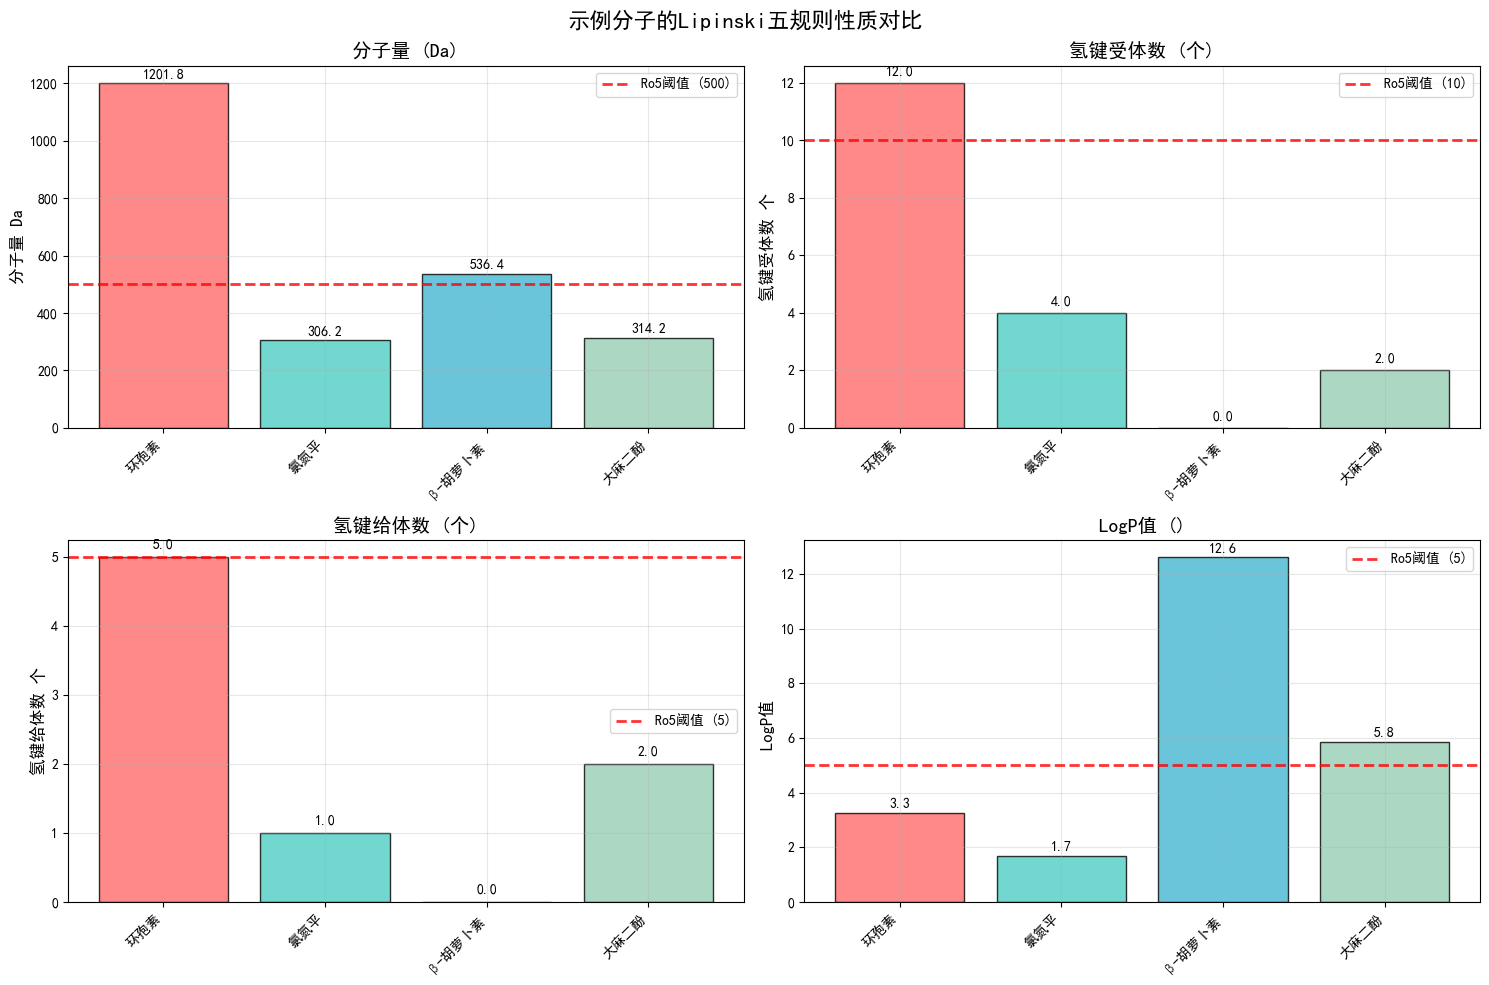

分子性质对比图已生成


In [15]:
# Cell 6: 创建分子性质对比柱状图
molecules_df_clean = molecules_df.dropna()  # 移除无效分子

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('示例分子的Lipinski五规则性质对比', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Ro5性质和阈值
properties = [
    ('分子量', 500, 'Da'),
    ('氢键受体数', 10, '个'),
    ('氢键给体数', 5, '个'),
    ('LogP值', 5, '')
]

for idx, (prop, threshold, unit) in enumerate(properties):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # 绘制柱状图
    bars = ax.bar(range(len(molecules_df_clean)), molecules_df_clean[prop], 
                 color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # 添加阈值线
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, 
              alpha=0.8, label=f'Ro5阈值 ({threshold})')
    
    # 设置标题和标签
    ax.set_title(f'{prop} ({unit})', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{prop} {unit}', fontsize=12)
    ax.set_xticks(range(len(molecules_df_clean)))
    ax.set_xticklabels(molecules_df_clean.index, rotation=45, ha='right', fontsize=10)
    
    # 添加数值标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + threshold*0.02,
               f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 添加网格和图例
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("分子性质对比图已生成")

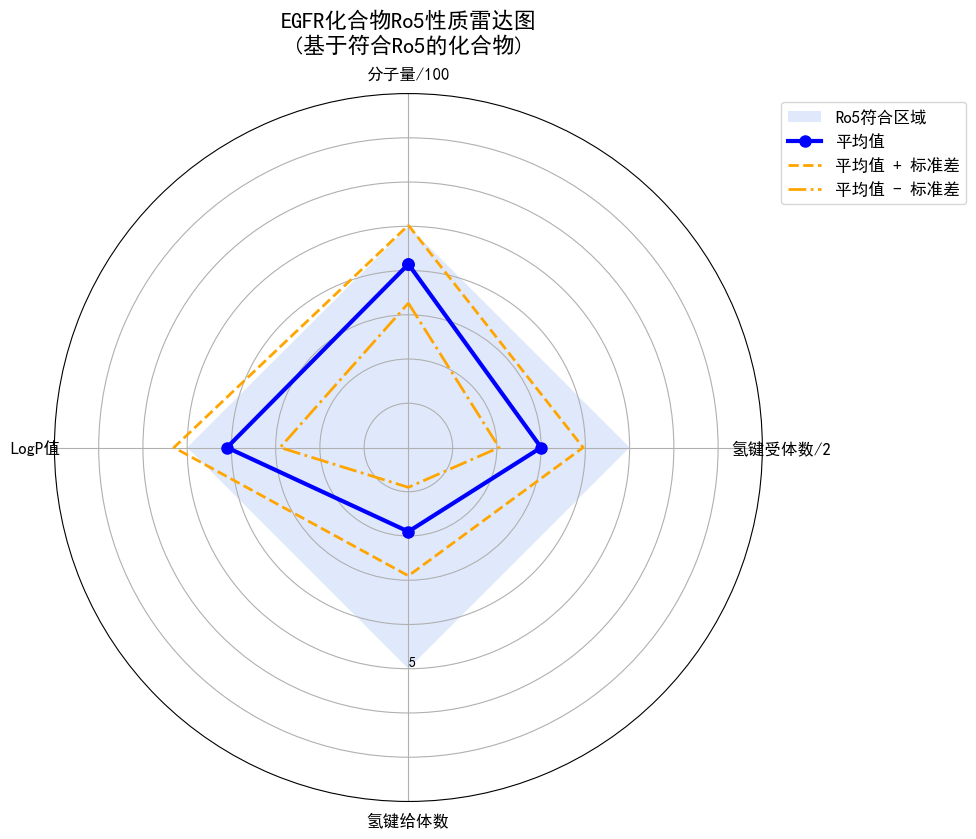

雷达图已生成


In [16]:
# Cell 7: 创建雷达图
def create_radar_plot():
    """创建雷达图显示分子性质"""
    
    # 模拟EGFR数据集统计（基于真实数据的近似值）
    stats_data = {
        '分子量': {'mean': 414.4, 'std': 88.0},
        '氢键受体数': {'mean': 6.0, 'std': 1.9},
        '氢键给体数': {'mean': 1.9, 'std': 1.0},
        'LogP值': {'mean': 4.1, 'std': 1.2}
    }
    
    # 转换为DataFrame
    stats_df = pd.DataFrame(stats_data).T
    
    # 缩放函数
    def scale_by_thresholds(data, thresholds, target_scale):
        scaled_data = data.copy()
        for prop in data.index:
            if prop in thresholds:
                scaled_data.loc[prop] = data.loc[prop] / thresholds[prop] * target_scale
        return scaled_data
    
    # 设置参数
    thresholds = {'分子量': 500, '氢键受体数': 10, '氢键给体数': 5, 'LogP值': 5}
    scaled_threshold = 5
    properties_labels = ['分子量/100', '氢键受体数/2', '氢键给体数', 'LogP值']
    
    # 定义角度
    angles = [i / float(len(stats_df)) * 2 * math.pi for i in range(len(stats_df))]
    angles += angles[:1]  # 闭合图形
    
    # 缩放数据
    y_scaled = scale_by_thresholds(stats_df, thresholds, scaled_threshold)
    y_scaled = pd.concat([y_scaled, y_scaled.head(1)])  # 闭合数据
    
    # 创建雷达图
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # 绘制Ro5符合区域
    ax.fill(angles, [scaled_threshold] * len(angles), 'cornflowerblue', 
           alpha=0.2, label='Ro5符合区域')
    
    # 绘制数据线
    ax.plot(angles, y_scaled['mean'], 'blue', lw=3, ls='-', 
           label='平均值', marker='o', markersize=8)
    ax.plot(angles, y_scaled['mean'] + y_scaled['std'], 'orange', 
           lw=2, ls='--', label='平均值 + 标准差')
    ax.plot(angles, y_scaled['mean'] - y_scaled['std'], 'orange', 
           lw=2, ls='-.', label='平均值 - 标准差')
    
    # 设置样式
    ax.set_theta_offset(math.pi / 2)  # 0度在顶部
    ax.set_theta_direction(-1)        # 顺时针
    ax.set_rlabel_position(180)       # y轴标签位置
    
    # 设置标签和刻度
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(properties_labels, fontsize=12)
    ax.set_ylim(0, 8)
    ax.set_yticks(range(1, 8))
    ax.set_yticklabels([str(i) if i == scaled_threshold else '' for i in range(1, 8)])
    
    # 添加标题和图例
    ax.set_title('EGFR化合物Ro5性质雷达图\n(基于符合Ro5的化合物)', 
                fontsize=16, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)
    
    plt.tight_layout()
    plt.show()

create_radar_plot()
print("雷达图已生成")

In [17]:
# Cell 8: 尝试加载T001数据进行分析
print("尝试加载T001数据进行大规模分析...")

# 查找可能的数据文件
possible_files = [
    'EGFR_compounds.csv',
    'egfr_compounds.csv', 
    'compounds.csv',
    'chembl_data.csv'
]

dataset = None
for filename in possible_files:
    if Path(filename).exists():
        try:
            dataset = pd.read_csv(filename)
            print(f"成功加载数据集: {filename}")
            print(f"   数据集形状: {dataset.shape}")
            print(f"   列名: {list(dataset.columns)}")
            break
        except Exception as e:
            print(f" 加载 {filename} 失败: {e}")

if dataset is None:
    print("未找到T001数据文件")
    print(" 提示: 如果你有T001的数据文件，请确保文件在当前目录下")
else:
    # 找到SMILES列
    smiles_col = None
    for col in dataset.columns:
        if 'smiles' in col.lower():
            smiles_col = col
            break
    
    if smiles_col:
        print(f"找到SMILES列: {smiles_col}")
        
        # 分析前10个分子作为示例
        print(f"\n分析前10个分子的Ro5性质...")
        sample_data = dataset.head(10)
        
        for idx, row in sample_data.iterrows():
            if pd.notna(row[smiles_col]):
                props = calculate_ro5_properties(row[smiles_col])
                if not props.isna().any():
                    status = "✅" if props['符合Ro5'] else "❌"
                    print(f"分子 {idx+1}: {status} (MW:{props['分子量']:.1f}, LogP:{props['LogP值']:.2f})")

尝试加载T001数据进行大规模分析...
未找到T001数据文件
 提示: 如果你有T001的数据文件，请确保文件在当前目录下


In [18]:
# Cell 9: 项目总结
print("🎯 T002项目完成总结")
print("=" * 60)
print("✅ 学习成果:")
print("   1. 理解了ADME概念和药物动力学")
print("   2. 掌握了Lipinski五规则的四个标准")
print("   3. 学会使用RDKit计算分子描述符")
print("   4. 分析了不同类型分子的药物样性质")
print("   5. 创建了专业的分子性质可视化")
print("   6. 应用Ro5原理筛选化合物")

print(f"\n Lipinski五规则总结:")
print("   分子量 ≤ 500 Da")
print("   氢键受体数 ≤ 10")
print("   氢键给体数 ≤ 5") 
print("   LogP值 ≤ 5")
print("   违反规则数 ≤ 1 (才算符合)")

print(f"\n示例分子结果:")
for name, properties in example_results.items():
    if not properties.isna().any():
        status = "符合" if properties['符合Ro5'] else "不符合"
        mw = properties['分子量']
        logp = properties['LogP值']
        print(f"   {name}: {status} Ro5 (MW:{mw:.1f}, LogP:{logp:.2f})")

print(f"\n 恭喜完成 T002: 分子过滤 - ADME和先导化合物相似性标准！")
print(f" 下一步: 可以继续学习 T003 (分子过滤：不良子结构)")

🎯 T002项目完成总结
✅ 学习成果:
   1. 理解了ADME概念和药物动力学
   2. 掌握了Lipinski五规则的四个标准
   3. 学会使用RDKit计算分子描述符
   4. 分析了不同类型分子的药物样性质
   5. 创建了专业的分子性质可视化
   6. 应用Ro5原理筛选化合物

 Lipinski五规则总结:
   分子量 ≤ 500 Da
   氢键受体数 ≤ 10
   氢键给体数 ≤ 5
   LogP值 ≤ 5
   违反规则数 ≤ 1 (才算符合)

示例分子结果:
   环孢素: 不符合 Ro5 (MW:1201.8, LogP:3.27)
   氯氮平: 符合 Ro5 (MW:306.2, LogP:1.68)
   β-胡萝卜素: 不符合 Ro5 (MW:536.4, LogP:12.61)
   大麻二酚: 符合 Ro5 (MW:314.2, LogP:5.85)

 恭喜完成 T002: 分子过滤 - ADME和先导化合物相似性标准！
 下一步: 可以继续学习 T003 (分子过滤：不良子结构)
